In [2]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image  # for loading images as YCbCr format
import scipy.misc
import scipy.ndimage
import numpy as np
import imageio
import tensorflow as tf
import time

In [4]:
filenames = os.listdir('Train')
print(filenames)

['t45.bmp', 't4.bmp', 't51.bmp', 't46.bmp', 't22.bmp', 't6.bmp', 't8.bmp', 't24.bmp', 't14.bmp', 'tt3.bmp', 'tt7.bmp', 'tt2.bmp', 't49.bmp', 't57.bmp', 't66.bmp', 't39.bmp', 't17.bmp', 't59.bmp', 'tt13.bmp', 't29.bmp', 't30.bmp', 't23.bmp', 't16.bmp', 't61.bmp', 't33.bmp', 'tt18.bmp', 'tt27.bmp', 't32.bmp', 't34.bmp', 'tt8.bmp', 't2.bmp', 't35.bmp', 'tt4.bmp', 't62.bmp', 't25.bmp', 't55.bmp', 't53.bmp', 'tt6.bmp', 't48.bmp', 't58.bmp', 't1.bmp', 't21.bmp', 't36.bmp', 't64.bmp', 'tt26.bmp', 't40.bmp', 't65.bmp', 'tt19.bmp', 'tt25.bmp', 't15.bmp', 'tt1.bmp', 't31.bmp', 't63.bmp', 'tt20.bmp', 't38.bmp', 'tt14.bmp', 'tt9.bmp', 't43.bmp', 't12.bmp', 't3.bmp', 't44.bmp', 't42.bmp', 't7.bmp', 'tt16.bmp', 't37.bmp', 't60.bmp', 'tt10.bmp', 't13.bmp', 't52.bmp', 't54.bmp', 'tt12.bmp', 'tt24.bmp', 't27.bmp', 'tt17.bmp', 't20.bmp', 'tt5.bmp', 'tt15.bmp', 't11.bmp', 't56.bmp', 't28.bmp', 'tt21.bmp', 't47.bmp', 't5.bmp', 'tt23.bmp', 't18.bmp', 't10.bmp', 't50.bmp', 't19.bmp', 't9.bmp', 't26.bmp', 't

In [5]:
sub_lr_sequence = []
sub_hr_sequence = []
image_size=33
label_size=21
edge = int((image_size - label_size) / 2)
stride = 14
for img_name in filenames:
    path = '/'.join(['Train', img_name])
    #image = imageio.imread(path, as_gray=True, pilmode='YCbCr').astype(np.float)
    image = imageio.imread(path, pilmode='YCbCr').astype(np.float)
    image = image[:,:,0]
    
    height, weight = image.shape
    height -= (height%3)
    weight -= (weight%3)
    image_hr = image[0: height, 0: weight]
    
    image_hr = image_hr / 255.

    image_lr = scipy.ndimage.interpolation.zoom(image_hr, (1./3), prefilter=False)
    image_lr = scipy.ndimage.interpolation.zoom(image_lr, (3/1.), prefilter=False)
    
    #现在image_hr和image_hr都是大图片
    #要将大图片分为小图片，分别为31， 其中中心取21
    
    for x in range(0, height-image_size+1, stride):
        for y in range(0, weight-image_size+1, stride):
            sub_img_lr = image_lr[x: x+image_size, y: y+image_size].reshape([image_size, image_size, 1])
            sub_img_hr = image_hr[x+edge: x+edge+label_size, y+edge: y+edge+label_size].reshape([label_size, label_size, 1])
            sub_lr_sequence.append(sub_img_lr)
            sub_hr_sequence.append(sub_img_hr)
            

In [6]:
for img_name in filenames:
    path = '/'.join(['Train', img_name])
    #image = imageio.imread(path, as_gray=True, pilmode='YCbCr').astype(np.float)
    image = imageio.imread(path, pilmode='YCbCr').astype(np.float)
    image = image[:,:,0]
    
    height, weight = image.shape
    height -= (height%3)
    weight -= (weight%3)
    image_hr = image[0: height, 0: weight]
    image_hr = image_hr / 255.
    
    image_hr = np.rot90(np.rot90(image_hr))

    image_lr = scipy.ndimage.interpolation.zoom(image_hr, (1./3), prefilter=False)
    image_lr = scipy.ndimage.interpolation.zoom(image_lr, (3/1.), prefilter=False)
    
    #现在image_hr和image_hr都是大图片
    #要将大图片分为小图片，分别为31， 其中中心取21
    
    for x in range(0, height-image_size+1, stride):
        for y in range(0, weight-image_size+1, stride):
            sub_img_lr = image_lr[x: x+image_size, y: y+image_size].reshape([image_size, image_size, 1])
            sub_img_hr = image_hr[x+edge: x+edge+label_size, y+edge: y+edge+label_size].reshape([label_size, label_size, 1])
            sub_lr_sequence.append(sub_img_lr)
            sub_hr_sequence.append(sub_img_hr)
            
lr_data = np.asarray(sub_lr_sequence) # [N, 33, 33, 1]
hr_data = np.asarray(sub_hr_sequence) # [N, 21, 21, 1]

In [7]:
def SRCNN(image, labels, image_size=33,label_size=21):

    w1 = tf.Variable(tf.random_normal([9, 9, 1, 64], stddev=1e-3), name='w1')
    b1 = tf.Variable(tf.zeros([64]), name='b1')
    conv1 = tf.nn.relu(tf.nn.conv2d(image, w1, strides=[1, 1, 1, 1], padding='VALID') + b1)
    #conv1 = tf.layers.conv2d(inputs=image, filters=64, kernel_size=[9, 9], padding='same')

    w2 = tf.Variable(tf.random_normal([1, 1, 64, 32], stddev=1e-3), name='w2')
    b2 = tf.Variable(tf.zeros([32]), name='b2')
    conv2 = tf.nn.relu(tf.nn.conv2d(conv1, w2, strides=[1, 1, 1, 1], padding='VALID') + b2)
    #conv2 = tf.layers.conv2d(inputs=conv1, filters=32, kernel_size=[1, 1], padding='same')

    w3 = tf.Variable(tf.random_normal([5, 5, 32, 1], stddev=1e-3), name='w3')
    b3 = tf.Variable(tf.zeros([1]), name='b3')
    conv3 = tf.nn.conv2d(conv2, w3, strides=[1, 1, 1, 1], padding='VALID') + b3
    #conv3 = tf.layers.conv2d(inputs=conv2, filters=1, kernel_size=[5, 5], padding='same')
    pred = conv3
    print(pred)
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.square(tf.subtract(labels, pred)))
        #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=pred))
    return pred, loss

def train_step(loss, learning_rate):
    with tf.name_scope('train_step'):
        step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return step

In [8]:
train_data = lr_data
train_label = hr_data
image_size=33
label_size=21
c_dim=1
batch_size=128
learning_rate=1e-3
epoch=50
total_loss = []

In [9]:
with tf.name_scope('inputs'):
        #images = tf.placeholder(tf.float32, [None, image_size, image_size, c_dim], name='images')
        images = tf.placeholder(tf.float32, [None, None, None, c_dim], name='images')
        #labels = tf.placeholder(tf.float32, [None, label_size, label_size, c_dim], name='labels')
        labels = tf.placeholder(tf.float32, [None, None, None, c_dim], name='labels')
pred, loss = SRCNN(images, labels, image_size, label_size)
iters = int(train_data.shape[0] / batch_size)
print('number of batches for training: {}'.format(iters))
step = train_step(loss, learning_rate)
counter = 0
iter_total = 0
cur_model_name = 'SRCNN_{}'.format(int(time.time()))
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    for epc in range(epoch):
        if epc % 50==0:
            print("epoch {} ".format(epc + 1)) 
        for itr in range(iters):
            counter += 1
            batch_images = train_data[itr * batch_size: (1 + itr) * batch_size]
            batch_labels = train_label[itr * batch_size: (1 + itr) * batch_size]
            
            _, cur_loss = sess.run([step, loss], feed_dict={images: batch_images, labels: batch_labels})
            total_loss.append(cur_loss)
            if counter % 5000 == 0:
                print('Epoch: {}, step: {}, loss: {}'.format(epc + 1, counter, cur_loss))
            if counter % 500 == 0:
                saver.save(sess, 'model_SRCNN/{}'.format(cur_model_name))

Instructions for updating:
Colocations handled automatically by placer.
Tensor("add_2:0", shape=(?, ?, ?, 1), dtype=float32)
number of batches for training: 341
epoch 1 
Epoch: 15, step: 5000, loss: 0.001822938909754157
Epoch: 30, step: 10000, loss: 0.0006645653047598898
Epoch: 44, step: 15000, loss: 0.003266851883381605


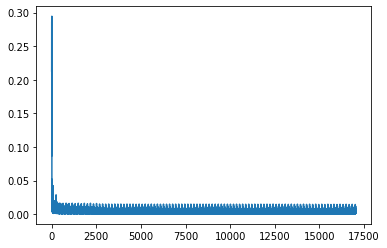

In [10]:
plt.plot(total_loss)

In [2]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image  # for loading images as YCbCr format
import scipy.misc
import scipy.ndimage
import numpy as np
import imageio
import tensorflow as tf
import time
import cv2

In [3]:
def compute_psnr(im1,im2):
    #imdff = im1.astype(np.float) - im2.astype(np.float)
    imdff = im1 - im2
    imdff = imdff.reshape((imdff.shape[0]*imdff.shape[1], 1))
    rmse = np.sqrt(np.mean(np.power(imdff, 2)))
    psnr = 20*np.log10(255/rmse)
    return psnr

In [82]:
#拼接一张图片测试原来merge 使用Test/Set14/comic.bmp
test_sub_lr_sequence = []
test_sub_hr_sequence = []
test_sub_lr21_sequence = []
test_path = 'Test/Set5/baby_GT.bmp'
test_image = imageio.imread(test_path, pilmode='YCbCr').astype(np.float)
#test_image2 = imageio.imread(test_path, as_gray=True, pilmode='YCbCr').astype(np.float)
#print(test_image.shape)
test_image, test_image_1, test_image_2= test_image[:,:,0], test_image[:,:,1], test_image[:,:,2]
#print(test_image2.shape)
#print(test_image-test_image2)
height, weight = test_image.shape
height -= (height%3)
weight -= (weight%3)
image_hr = test_image[0: height, 0: weight]

print(image_hr.shape)
image_hr = image_hr / 255.

image_lr = scipy.ndimage.interpolation.zoom(image_hr, (1./3), prefilter=False)
image_lr = scipy.ndimage.interpolation.zoom(image_lr, (3/1.), prefilter=False)
im_input = image_lr.reshape((1,image_lr.shape[0],image_lr.shape[1],1))
im_lr = image_lr
print(image_lr.shape)
image_size=33
label_size=21
edge = int((image_size - label_size) / 2)
stride  = 14

nx = ny = 0
for x in range(0, height-image_size+1, stride):
    nx += 1
    ny = 0
    for y in range(0, weight-image_size+1, stride):
        ny += 1
        sub_img_lr = image_lr[x: x+image_size, y: y+image_size].reshape([image_size, image_size, 1])
        sub_img_hr = image_hr[x+edge: x+edge+label_size, y+edge: y+edge+label_size].reshape([label_size, label_size, 1])
        sub_img_lr21 = image_lr[x+edge: x+edge+label_size, y+edge: y+edge+label_size].reshape([label_size, label_size, 1])
        test_sub_lr_sequence.append(sub_img_lr)
        test_sub_hr_sequence.append(sub_img_hr)
        test_sub_lr21_sequence.append(sub_img_lr21)
        
test_lr_data = np.asarray(test_sub_lr_sequence)
test_hr_data = np.asarray(test_sub_hr_sequence)
test_lr21_data = np.asarray(test_sub_lr21_sequence)

(510, 510)
(510, 510)


In [83]:
print(image_hr.shape)
print(image_lr.shape)

print(test_hr_data.shape)
print(test_lr_data.shape)
print(test_lr21_data.shape)
print(nx, ny)

(510, 510)
(510, 510)
(1225, 21, 21, 1)
(1225, 33, 33, 1)
(1225, 21, 21, 1)
35 35


In [84]:
tf.reset_default_graph()
with tf.Session() as sess:
    saver=tf.train.import_meta_graph('model_SRCNN/SRCNN_1576460600.meta')
    saver.restore(sess, tf.train.latest_checkpoint('model_SRCNN/'))
    graph=tf.get_default_graph()
    image=graph.get_tensor_by_name("inputs/images:0")
    result=graph.get_tensor_by_name('add_2:0')
    print(image)
    print(result)
    out = sess.run(result, feed_dict={image:test_lr_data})
    out2 = sess.run(result, feed_dict={image:im_input})
    print(out.shape)

INFO:tensorflow:Restoring parameters from model_SRCNN/SRCNN_1576460600
Tensor("inputs/images:0", shape=(?, ?, ?, 1), dtype=float32)
Tensor("add_2:0", shape=(?, ?, ?, 1), dtype=float32)
(1225, 21, 21, 1)


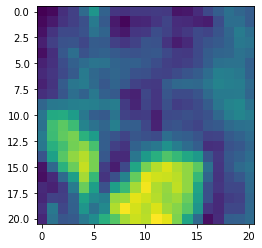

In [85]:
a = 99
plt.imshow(test_hr_data[a,:,:,0])

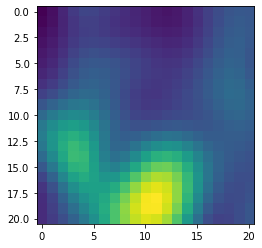

In [86]:
plt.imshow(test_lr21_data[a,:,:,0])

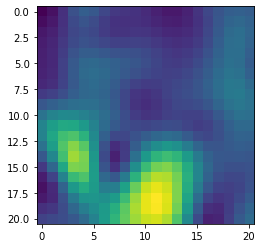

In [87]:
plt.imshow(out[a,:,:,0])

# SRCNN

(1, 498, 498, 1)


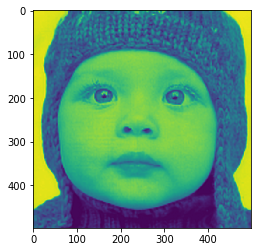

In [89]:
plt.imshow(out2[0,:,:,0])
print(out2.shape)

# Bicubic

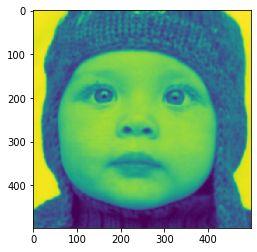

In [90]:
plt.imshow(im_lr[6:6+498, 6:6+498])

# Origin

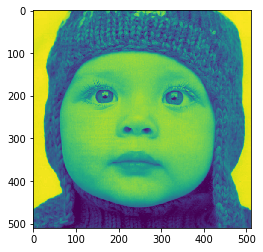

In [91]:
plt.imshow(image_hr)

In [93]:
psnr_bic3 = compute_psnr(image_hr[6:6+498, 6:6+498]*255, im_lr[6:6+498, 6:6+498]*255)
psnr_bic4 = compute_psnr(image_hr[6:6+498, 6:6+498]*255, out2[0,:,:,0]*255)
print('PSNR for Bicubic {}'.format(psnr_bic3))
print('PSNR for SRCNN {}'.format(psnr_bic4))

PSNR for Bicubic 30.17507694790617
PSNR for SRCNN 32.658318015438816


In [81]:
scipy.misc.imsave('Sample/baby_GT_hr.jpg', image_hr)
scipy.misc.imsave('Sample/baby_GT_lr.jpg', im_lr[6:6+330, 6:6+216])
scipy.misc.imsave('Sample/baby_GT_SRCNN.jpg', out2[0,:,:,0])

/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
